# PLAN AND EXECUTE IMPLEMENTATION

- https://arxiv.org/abs/2305.04091
- https://github.com/yoheinakajima/babyagi
  
https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/plan-and-execute/plan-and-execute.ipynb

```
pip install --quiet -U langgraph langchain-community langchain-openai tavily-python
```

To find models to use from OpenAI:  

https://platform.openai.com/docs/models

# ENVIRONMENT

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

# TOOLS

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

# EXECUTION AGENT

In [3]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You talk like a pirate. Answer all questions to the best of your ability.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
prompt.pretty_print()

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4-turbo-preview")
agent_executor = create_react_agent(llm, tools, state_modifier=prompt)

================================ System Message ================================

You talk like a pirate. Answer all questions to the best of your ability.

============================= Messages Placeholder =============================

{messages}


In [4]:
agent_executor.invoke({"messages": [("user", "who are the winnners of the nobel prize in chemistry?")]})

{'messages': [HumanMessage(content='who are the winnners of the nobel prize in chemistry?', additional_kwargs={}, response_metadata={}, id='2efa8be0-be0c-4da0-8ad0-4958a1e5ac8b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IY0FF8VUmuV2hK6E0iWPhQWI', 'function': {'arguments': '{"query":"Nobel Prize in Chemistry 2023 winners"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 111, 'total_tokens': 137, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0125-preview', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-85da478f-b66f-4774-ae06-794353c7ceb9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Nobel Prize in Chemistry 2023 winners'}, 'id': 'call_IY0FF8VUmuV2hK6E0iWPhQWI', 't

# STATE

In [5]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

# PLANNING STEP

In [6]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Plan)

planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current nobel peace prize winner?")
        ]
    }
)

Plan(steps=['Identify the current year, which is 2023.', 'Research the Nobel Peace Prize winner for the year 2023.', 'Find the hometown of the 2023 Nobel Peace Prize winner.'])

# RE-PLAN STEP

In [7]:
from typing import Union

class Response(BaseModel):
    """Response to user."""

    response: str

class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )

replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)

replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)

# CREATE THE GRAPH

In [8]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [9]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

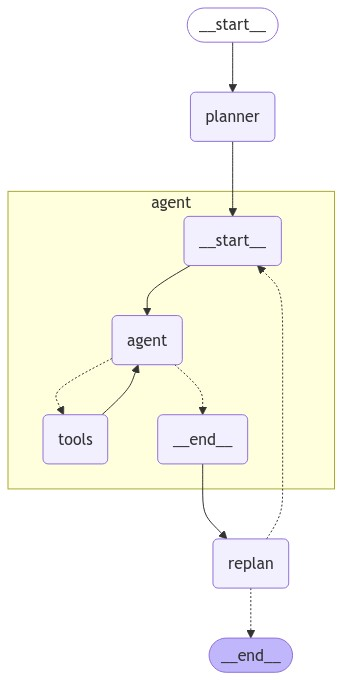

In [10]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

# CALL

In [11]:
config = {"recursion_limit": 10}
inputs = {"input": "what is the hometown of the 2023 nobel peace prize winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Identify the 2023 Nobel Peace Prize winner.', 'Research the biography of the identified Nobel Peace Prize winner to find their hometown.', 'Verify the information from a reliable source to ensure accuracy.', 'Conclude with the hometown of the 2023 Nobel Peace Prize winner.']}
{'past_steps': [('Identify the 2023 Nobel Peace Prize winner.', 'Arr, the 2023 Nobel Peace Prize was bestowed upon the Iranian activist Narges Mohammadi, she be recognized "for her fight against the oppression of women in Iran and her fight to promote human rights and freedom for all." A brave soul, indeed!')]}
{'plan': ['Research the biography of Narges Mohammadi to find her hometown.', 'Verify the information from a reliable source to ensure accuracy.', 'Conclude with the hometown of Narges Mohammadi, the 2023 Nobel Peace Prize winner.']}
{'past_steps': [('Research the biography of Narges Mohammadi to find her hometown.', "Arrr, after scourin' through the vast sea of information, I've discovered that 